# Usage Example of Pyspectrum
pyspectrum is a package that deals with spectra. it includes spectrum and peak realization,
finding peak method based on the convolution and Marsicotti method, Calibration methds and fitting procdures.
In this notebook presented an example for each of this methods

In [1]:
from pyspectrum import Spectrum, FindPeaksDomain, FindPeaksCenters, Convolution, GaussianWithBGFitting, Calibration
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspectrum.peak_identification.zero_area_functions import gaussian_2_dev
from uncertainties import ufloat

# Loading a new spectrum
The spectrum is of Eu152, and there was not calibration yet.

In [2]:
path = './spectra/152Eu_calsource_10cm_85ks.txt'
spectrum = pd.read_csv(path, names=['counts'])
spectrum['channel'] = spectrum.index 
spectrum = Spectrum.from_dataframe(spectrum)

Text(0, 0.5, 'counts')

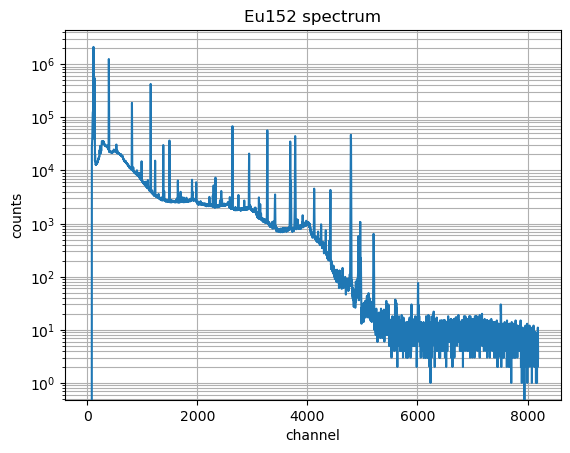

In [3]:
spectrum.xr_spectrum().plot(yscale='log')
plt.grid(True, which='both')
plt.title('Eu152 spectrum')
plt.xlabel('channel')
plt.ylabel('counts')

## calibration generator

### i choose the obvious photobpeaks in the spectrum

In [4]:
domains = [(383, 403), (1140,1165), (1485, 1505), (2627, 2650), (3260,3285), (4770, 4810), (5180, 5230)]
energies = [121.78, 344.28, 443.96, 778.9, 964.08, 1408, 1528.1]

In [5]:
calib = Calibration(spectrum.xr_spectrum(), energies, domains)
energy_calibration, resolution_calibration = calib.generate_calibration(1)
spectrum.energy_calibration = energy_calibration
spectrum.fwhm_calibration = lambda x: resolution_calibration(x)

Now there is a calibration 

## findPeaks
An example how to find domains in which the counts are above snr

In [6]:
# The find peaks method (maybe it should be self contained)
convolution = Convolution(spectrum.fwhm_calibration, gaussian_2_dev)
find_peaks = FindPeaksDomain(spectrum, convolution, n_sigma_threshold=4)
peaks_domain = find_peaks.find_domains_above_snr()

In [7]:
spectrum.energy_calibration(peaks_domain)[1:5]

array([[71.43245241, 76.98799438],
       [79.034773  , 80.78915467],
       [81.08155162, 82.54353635],
       [83.12833024, 86.0522997 ]])

(1000.0, 1000000.0)

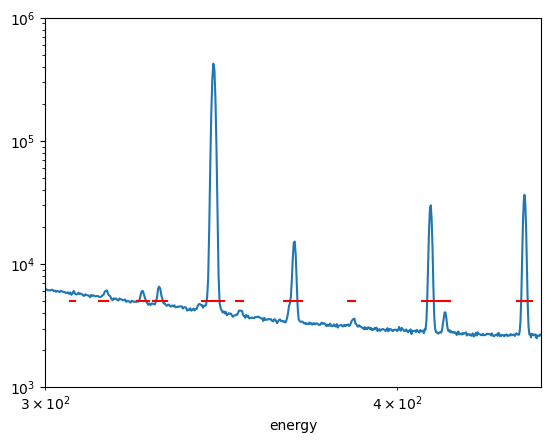

In [16]:
spectrum.xr_spectrum().plot(yscale='log', xscale='log')
for domain in energy_calibration(peaks_domain):
    plt.hlines(y=5e3, xmin=domain[0], xmax=domain[1], linestyles='-', colors='red')
plt.hlines(y=3, xmax=4600, xmin=400)
plt.xlim([300  ,  450])
plt.ylim([1e3,1e6])

The peaks center can be found using the Mariscotti method

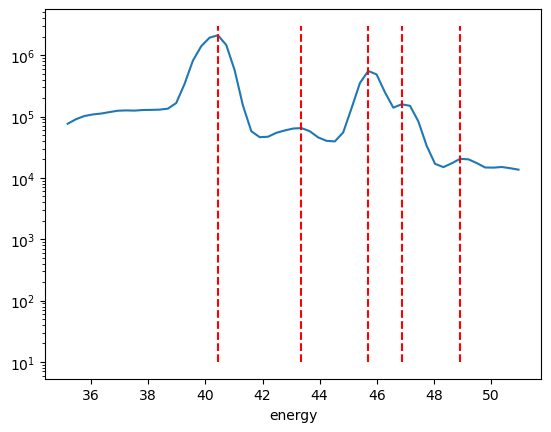

In [17]:
spectrum.xr_spectrum().sel(energy=slice(35,51)).plot(yscale='log')
minimal_statistical_accuracy = 0.05
f_local = spectrum.fwhm_calibration(25)
resolution = f / (2 * np.sqrt(2 * np.log(2)))
minimal_counts_in_peak = 1 / minimal_statistical_accuracy ** 2
minimal_prominence = minimal_counts_in_peak / (0.761438079 * np.sqrt(2 * np.pi) * resolution)
fp = FindPeaksCenters(spectrum.xr_spectrum().sel(energy=slice(24,51)), resolution/4, minimal_prominence)
for c in fp():
    plt.vlines(ymax=3e6, ymin=10, x=c, color='red', ls='--')

Spectrm can be analayzed easily, this is exampled here by fitting all of the peaks

In [ ]:
# note that using plot_all_peaks shows all the peaks in
plt.axes(yscale='log')
spectrum.plot_all_peaks(n_sigma_threshold=4, minimal_statistical_accuracy=0.1, smoothing_factor=4)
plt.grid(True, which='both')
plt.title('Eu152 spectrum')
plt.xlabel('channel')
plt.ylabel('counts')
plt.show()
#plt.xlim([100, 500])
#plt.ylim([1e0, 1e5])

in here the fitting is saved in x and y

In [ ]:
x, y = spectrum.fit_peaks(n_sigma_threshold=4, minimal_statistical_accuracy=0.1)

In [ ]:
spectrum.xr_spectrum().plot(yscale='log')

for i, peak in enumerate(x):
    energy_domain = spectrum.energy_calibration(np.arange(y[i][0], y[i][1], 1))
    GaussianWithBGFitting.plot_fit(energy_domain, peak)
#plt.xlim([100,2000])
#plt.ylim([5e2,spectrum.xr_spectrum().max().values])
plt.grid(which='both')
plt.legend(['spectrum', 'fit'])

In [ ]:
x = {1:1, 2:2, 3:3}
sum(x.values())